In [1]:
import matplotlib.pyplot as plt 

import scipy.ndimage.filters
import scipy.stats

from skimage.transform import pyramid_laplacian

from PIL import Image
from PIL import ImageFilter

import numpy as np

/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = numpy.mgrid[-size:size+1, -size_y:size_y+1]
    g = numpy.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

In [3]:
class pyramid(object):
    g_data=[]
    l_data=[]
    
    def __init__(self,file_path,n=5):
        self.g_data=[]
        self.l_data=[]
        im = Image.open(file_path)
        prev=np.asarray(im,dtype=np.float64)/255.0
#         print(prev.shape)
        self.g_data.append(prev)
        
#         plt.imshow(prev, cmap="Greys_r")
#         plt.imshow(np.subtract(prev,self._blur(prev)),cmap="Greys_r")
        for i in range(n):
            the_blur=pyramid.blur(prev)
            diff=prev-the_blur
            self.l_data.append(diff)
            smaller=pyramid.subsample(the_blur)
            self.g_data.append(smaller)
            prev=smaller
            
        self.l_data.append(self.g_data[-1])
    
    
# A wrong way of making laplacian pyramids
#         rev =list(reversed(self.g_data))
#         for i in range(n):              
#             expanded=scipy.ndimage.interpolation.zoom(rev[i],2,order=0)
# #             print expanded.shape
#             expanded=self._blur(expanded)
#             diff=rev[i+1]-expanded
#             self.l_data.append(diff)
            
            
    @staticmethod
    def blur(img_arr):
#         kernel = generating_kernel(0.4)
#         return scipy.signal.convolve2d(img_arr,kernel,'same')
#         return skimage.filters.gaussian(img_arr,sigm=1)
        return scipy.ndimage.filters.gaussian_filter(img_arr, 1,order=0)
    
    @staticmethod
    def subsample(img_arr):
        sub_arr = img_arr[::2,::2]
        return sub_arr    
    
    @staticmethod
    def supersample(img_arr):
        new_arr=scipy.ndimage.interpolation.zoom(img_arr,2,order=0)
        for x in range(new_arr.shape[0]):
            if x%2==1:
                new_arr[:,x]=np.zeros(new_arr.shape[1])
        for y in range(new_arr.shape[1]):
            if y%2==1:
                new_arr[y,:]=np.zeros(new_arr.shape[0])
        return new_arr
      
    @staticmethod
    def reconstruct(lapl):
        rev_lapl =list(reversed(lapl))
        gauss=lapl[-1]
        for i in range(len(lapl)-1):
            up=pyramid.supersample(gauss)
#             blurred=up
            blurred=pyramid.blur(up)
            added=blurred+rev_lapl[i+1]
#             plt.imshow(rev_lepl[i+1])
            gauss=added
        return gauss
#             plt.figure()
#             plt.imshow(gauss,cmap="Greys_r")
            
#         plt.imshow(self._blur(self._supersample(lapl[-1])+lapl[-2]),cmap="Greys_r")
        

    
    def level(self,i):
        return self.g_data[i]
        
    def show(self,source):
        for i in range(len(source)):
            plt.figure()
            plt.imshow(source[i], cmap="Greys_r")
            
    def show_g(self):
        self.show(self.g_data)
        
    def show_l(self):
        self.show(self.l_data)

        

        
        
        
        

In [14]:
    #alternate expansion solution for validation
    def generating_kernel(a):
        w_1d = np.array([0.25 - a/2.0, 0.25, a, 0.25, 0.25 - a/2.0])
        return np.outer(w_1d, w_1d)
    
    def iexpand(image):
        out = None
        kernel = generating_kernel(0.4)
        outimage = np.zeros((image.shape[0]*2, image.shape[1]*2), dtype=np.float64)
        outimage[::2,::2]=image[:,:]
#         out =4*pyramid.blur(outimage)
        out = 4*scipy.signal.convolve2d(outimage,kernel,'same')
        return out
    
    def collapse(lapl_pyr):
        output = None
        output = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
        for i in range(len(lapl_pyr)-1,0,-1):
            lap = iexpand(lapl_pyr[i])
            lapb = lapl_pyr[i-1]
            if lap.shape[0] > lapb.shape[0]:
                lap = np.delete(lap,(-1),axis=0)
            if lap.shape[1] > lapb.shape[1]:
                lap = np.delete(lap,(-1),axis=1)
            tmp = lap + lapb
            lapl_pyr.pop()
            lapl_pyr.pop()
            lapl_pyr.append(tmp)
            output = tmp
        return output

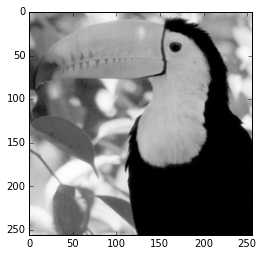

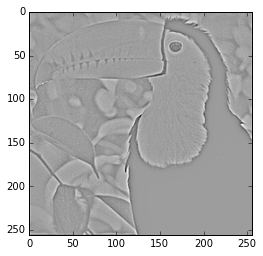

In [15]:
%matplotlib inline
p=pyramid("Images/Q1/toucan.tif")
image=np.asarray(Image.open("Images/Q1/toucan.tif"),dtype=np.float64)/255.0
# print(image[0][0])
# p.show_g()
# p.show_l()

laplacian=p.l_data
new_image=pyramid.reconstruct(laplacian)
# new_image=collapse(laplacian)
plt.figure()
plt.imshow(image,cmap="Greys_r")
# new_image=new_image/np.max(new_image)
plt.figure()
plt.imshow(new_image,cmap="Greys_r")

# print(np.sum(np.absolute(image-new_image)))

# print(p.l_data[0])
# x=np.array([[1,2],[3,4]])
# print(p._supersample(x))
    
# p._supersample(x)




# image=np.asarray(Image.open("Images/Q1/mandril.tif"),dtype=np.float64)/255.0
# # plt.imshow(image,cmap="Greys_r")
# thing=pyramid_laplacian(image, max_layer=-1, downscale=2, sigma=2, order=1, mode='reflect', cval=0)
# for x in thing:
#     print(x[0][0])
# #     plt.figure()
# #     plt.imshow(x, cmap="Greys_r")
#     break
# print(p.l_data[-1])
# print(p.l2_data[0][0][0])
# print np.asarray(Image.open("Images/Q1/lena_gray.gif"))
# p=g_pyramid("Images/Q1/lena_gray.gif")
# p.show_all()
# p.show_l()
# p.show_g()
# plt.imshow(p.level(-1), cmap="Greys_r")


In [16]:
#algorithm defined http://web.engr.illinois.edu/~goodsit2/cs498dwh/final/
#and http://www.jcomputers.us/vol6/jcp0612-07.pdf
def calc_dev(region):
    return np.std(region)
def entropy(region):
    return scipy.stats.entropy(region) 
def window():
    return np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])/256.0
def energy(region):
    region=np.reshape(region,(5,5))
    sq=np.square(region)
    mult=np.multiply(window(),sq)
    return np.sum(mult)

def fuse_top(imgA,imgB):
    size=(3,3)
    devA=scipy.ndimage.filters.generic_filter(imgA,calc_dev,size)
    devB=scipy.ndimage.filters.generic_filter(imgB,calc_dev,size)
    entA=scipy.ndimage.filters.generic_filter(imgA,entropy,size)
    entB=scipy.ndimage.filters.generic_filter(imgB,entropy,size)
    img_size=imgA.shape
    to_return=[]
    for i in range(imgA.shape[0]):
        for j in range(imgA.shape[1]):
#             if entA[i][j]>=entB[i][j]:
            if devA[i][j]>=devB[i][j] and entA[i][j]>=entB[i][j]:
                to_return.append(imgA[i][j])
#             if entA[i][j]<entB[i][j]:
            elif devA[i][j]<devB[i][j] and entA[i][j]<entB[i][j]:
                to_return.append(imgB[i][j])
            else:
#                 to_return.append(0.0)
                to_return.append((imgA[i][j]+imgB[i][j])/2.0)
#     print(img_size)
    return np.resize(np.array(to_return),img_size)

def fuse_rest(imgA,imgB):
    size=(5,5)
    enA=scipy.ndimage.filters.generic_filter(imgA,energy,size)
    enB=scipy.ndimage.filters.generic_filter(imgB,energy,size)
    img_size=imgA.shape
    to_return=[]
    
    for i in range(imgA.shape[0]):
        for j in range(imgA.shape[1]):
            if enA[i][j]>=enB[i][j]:
                to_return.append(imgA[i][j])
            else:
                to_return.append(imgB[i][j])
    return np.resize(np.array(to_return),img_size)


def fuse_pyramid(pyA,pyB):
    new_pyramid=[]
    for i in range(len(pyA)):
        #this might be wrong, it might need to be the last element
        if i==0:
            new_pyramid.append(fuse_top(pyA[i],pyB[i]))
        else:
            new_pyramid.append(fuse_rest(pyA[i],pyB[i]))              
    return new_pyramid



array([[ 0.06078431,  0.08235294,  0.08627451, ...,  0.31176471,
         0.30980392,  0.3       ],
       [ 0.0627451 ,  0.09019608,  0.08823529, ...,  0.28039216,
         0.35686275,  0.3254902 ],
       [ 0.0745098 ,  0.10980392,  0.10784314, ...,  0.33333333,
         0.44509804,  0.33137255],
       ..., 
       [ 0.71176471,  0.72745098,  0.71372549, ...,  0.2254902 ,
         0.21960784,  0.18039216],
       [ 0.69803922,  0.73137255,  0.72156863, ...,  0.2       ,
         0.21764706,  0.19607843],
       [ 0.70980392,  0.75686275,  0.73921569, ...,  0.21568627,
         0.25882353,  0.23529412]])

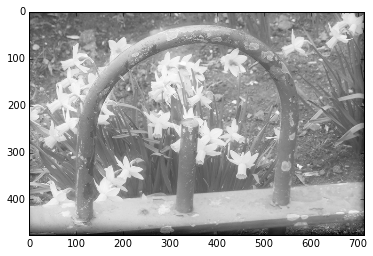

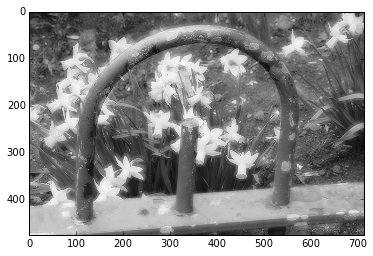

In [18]:
def experiment(plot=True):
    #what happens if we just try to apply the fusing to the images straight up?
    focus1=np.asarray(Image.open("Images/Q1/focus1.tif"),dtype=np.float64)/255.0
    focus2=np.asarray(Image.open("Images/Q1/focus2.tif"),dtype=np.float64)/255.0
    fused=fuse_top(focus1,focus2)
    
    if plot:
        plt.figure()
        plt.imshow(focus1,cmap="Greys_r")
        plt.figure()
        plt.imshow(focus2,cmap="Greys_r")
        plt.figure()
        plt.imshow(fused,cmap="Greys_r")
    return fused

def experiment2(plot=True):
    #Is this overly complex? What if we just average?
    focus1=np.asarray(Image.open("Images/Q1/focus1.tif"),dtype=np.float64)/255.0
    focus2=np.asarray(Image.open("Images/Q1/focus2.tif"),dtype=np.float64)/255.0
    fused=(focus1+focus2)/2.0
    if plot:
#         plt.figure()
#         plt.imshow(focus1,cmap="Greys_r")
#         plt.figure()
#         plt.imshow(focus2,cmap="Greys_r")
        plt.figure()
        plt.imshow(fused,cmap="Greys_r")
    return fused
    
def right_way(plot=True):
    
    pf1=pyramid("Images/Q1/focus1.tif")
    pf2=pyramid("Images/Q1/focus2.tif")
    l1=pf1.l_data
    l2=pf2.l_data

    #add the gaussian back on at the end.
    fused=fuse_pyramid(l1,l2)
#     fused.append(pf1.l_data[-1])
    new_image=collapse(fused)

    if plot:
        focus1=np.asarray(Image.open("Images/Q1/focus1.tif"),dtype=np.float64)/255.0
        focus2=np.asarray(Image.open("Images/Q1/focus2.tif"),dtype=np.float64)/255.0
#         plt.figure()
#         plt.imshow(focus1,cmap="Greys_r")
#         plt.figure()
#         plt.imshow(focus2,cmap="Greys_r")
        plt.figure()
        plt.imshow(new_image,cmap="Greys_r")
    return new_image

a=right_way()
# b=(a+np.absolute(np.min(a)))*4
# plt.figure()
# plt.imshow(b,"Greys_r")
experiment2()
  
